# Train a spec2vec model on mass spectra dataset

In [1]:
import os
import sys
import gensim
import numpy as np
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

In [4]:
print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))
print("Careful: Number of spectra with < 10 peaks:", np.sum(np.array(number_of_peaks)<10))

Maximum number of peaks in one spectrum: 361421
Number of spectra with > 1000 peaks: 2698
Number of spectra with > 2000 peaks: 1440
Number of spectra with > 5000 peaks: 485
Careful: Number of spectra with < 10 peaks: 908


Text(0, 0.5, 'number of spectra in respective bin')

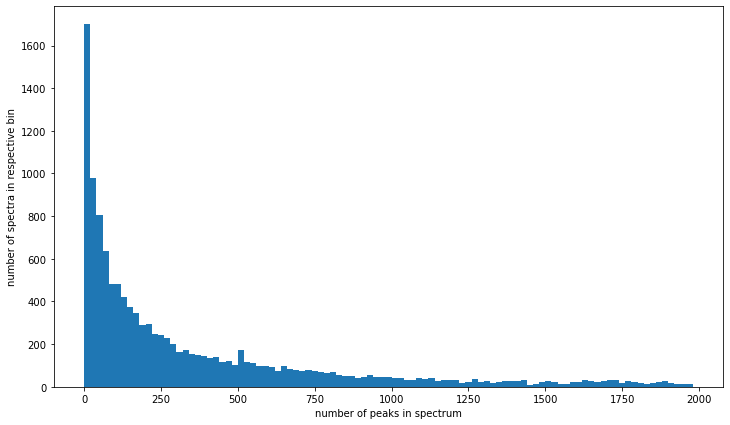

In [5]:
plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

### Post-process spectra - Step 1
+ Normalize spectrum
+ Remove peaks outside m/z ratios between 0 and 1000.0
+ Discard spectra with less then 10 remaining peaks

In [6]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

In [7]:
def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

# apply post processing steps to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

In [8]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))
print("Careful: Number of spectra with < 10 peaks:", np.sum(np.array(number_of_peaks)<10))

Maximum number of peaks in one spectrum: 228989
Number of spectra with > 1000 peaks: 2497
Number of spectra with > 2000 peaks: 1222
Number of spectra with > 5000 peaks: 335
Careful: Number of spectra with < 10 peaks: 0


Text(0, 0.5, 'number of spectra in respective bin')

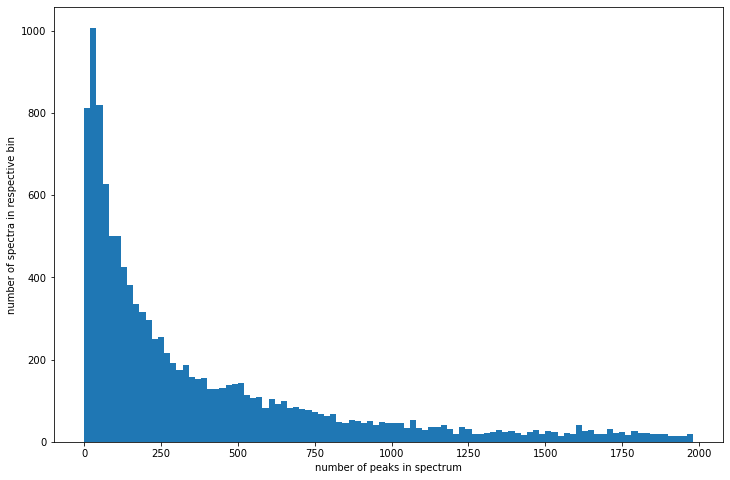

In [9]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

### Post-process spectra - step 2
+ Reduce number of peaks (scaled with parent-mass).

In [10]:
def post_process_step2(s):
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    return s

# apply post processing steps to the data
spectrums = [post_process_step2(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]

In [11]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))

Maximum number of peaks in one spectrum: 1001
Number of spectra with > 1000 peaks: 1
Number of spectra with > 2000 peaks: 0
Number of spectra with > 5000 peaks: 0


Text(0, 0.5, 'number of spectra in respective bin')

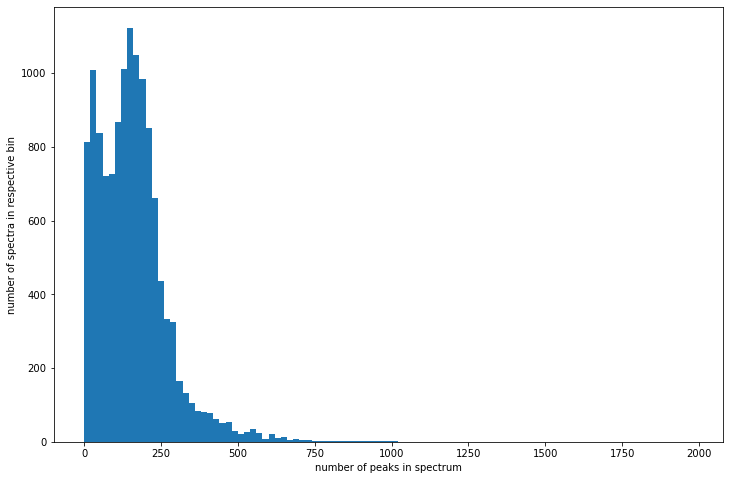

In [12]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

### Remove small peaks (<0.001 rel. intensity) if at least 10 peaks would remain

In [13]:
spectrums_postprocessed = []
for spec in spectrums:
    s = select_by_relative_intensity(spec, intensity_from=0.001)
    if len(s.peaks) >= 10:
        spectrums_postprocessed.append(s)
    else:
        spectrums_postprocessed.append(spec.clone())

In [14]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_postprocessed]

print("Maximum number of peaks in one spectrum:", np.max(number_of_peaks))
print("Number of spectra with > 1000 peaks:", np.sum(np.array(number_of_peaks)>1000))
print("Number of spectra with > 2000 peaks:", np.sum(np.array(number_of_peaks)>2000))
print("Number of spectra with > 5000 peaks:", np.sum(np.array(number_of_peaks)>5000))
print("Careful: Number of spectra with < 10 peaks:", np.sum(np.array(number_of_peaks)<10))

Maximum number of peaks in one spectrum: 1001
Number of spectra with > 1000 peaks: 1
Number of spectra with > 2000 peaks: 0
Number of spectra with > 5000 peaks: 0
Careful: Number of spectra with < 10 peaks: 0


Text(0, 0.5, 'number of spectra in respective bin')

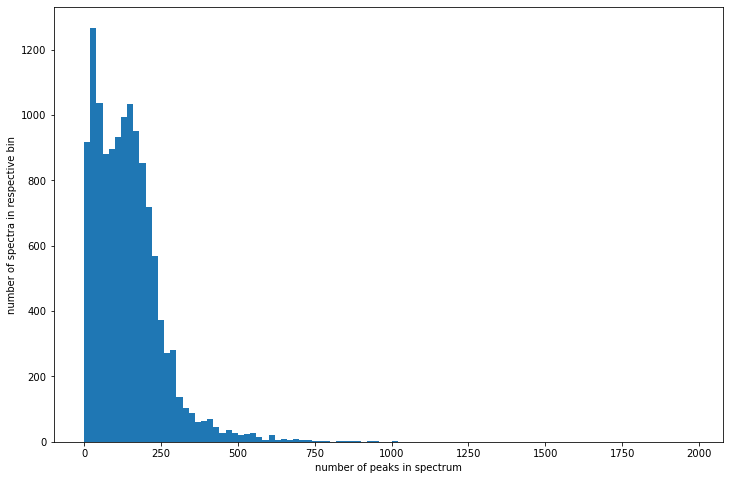

In [15]:
plt.figure(figsize=(12,8))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Add neutral losses (within 0 to 200 m/z)

In [16]:
spectrums_postprocessed = [add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0) for s in spectrums_postprocessed]

# Convert spectra to document and train spec2vec model

In [17]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [18]:
documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_postprocessed]

In [19]:
documents[0].words[:10]

['peak@289.29',
 'peak@295.55',
 'peak@298.49',
 'peak@317.32',
 'peak@319.66',
 'peak@324.48',
 'peak@325.32',
 'peak@339.79',
 'peak@343.95',
 'peak@347.02']

## Train word2vec model
+ Save model for every epoch in ``iterations``
+ Use default spec2vec parameters as set in ``train_new_word2vec_model()``
        "sg": 0,
        "negative": 5,
        "size": 300,
        "window": 500,
        "min_count": 1,
        "workers": 4,
        "learning_rate_initial": 0.025,
        "learning_rate_decay": 0.00025,
        "progress_logger": True

In [20]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_UniqueInchikeys_ratio05_filtered.model")

iterations = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

# Train model with default parameters
model = train_new_word2vec_model(documents, iterations, model_file)

  Epoch 1 of 100.Change in loss after epoch 1: 1658450.875
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_ratio05_filtered_iter_1.model
  Epoch 2 of 100.Change in loss after epoch 2: 1357940.375
  Epoch 3 of 100.Change in loss after epoch 3: 1228498.75
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_ratio05_filtered_iter_3.model
  Epoch 4 of 100.Change in loss after epoch 4: 1103882.5
  Epoch 5 of 100.Change in loss after epoch 5: 1061224.5
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_ratio05_filtered_iter_5.model
  Epoch 6 of 100.Change in loss after epoch 6: 1042830.5
  Epoch 7 of 100.Change in loss after epoch 7: 1005758.5
  Epoch 8 of 100.Change in loss after epoch 8: 860897.0
  Epoch 9 of 10

  Epoch 100 of 100.Change in loss after epoch 100: 117480.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_UniqueInchikeys_ratio05_filtered.model
